In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns

In [2]:
input_data = pickle.load(open('../../model/output/german0316_margin_0.5_alpha_0.95_multiply.pkl', 'rb'))
rules = input_data['paths']

In [3]:
s_conf = np.zeros(len(rules[0]['sample']))
for r in rules:
    s_conf += np.array(r['sample'])# * r['value']
s_conf /= np.max(np.abs(s_conf))
r_conf = np.array([r['confidence'] for r in rules])
mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

In [238]:
def anomaly_detection(mat, row_conf = None, col_conf = None, n_neighbors = 20, lambda_ = None):
    if row_conf is None:
        row_conf = np.ones(mat.shape[0])
    if col_conf is None:
        col_conf = np.ones(mat.shape[1])
    mat_t = mat.copy().transpose()
    for i in range(mat.shape[0]):
        mat[i, :] /= mat[i].sum()
    for i in range(mat_t.shape[0]):
        mat_t[i, :] /= mat_t[i].sum()

    row_weight = row_conf / np.sum(row_conf)
    col_weight = col_conf / np.sum(col_conf)

    for i in range(8):
        X = (mat * col_weight).transpose() * row_weight
        r_dist = pairwise_distances(X = X.transpose(), metric='euclidean')
        clf = LocalOutlierFactor(metric="precomputed", n_neighbors=n_neighbors)
        clf.fit(r_dist)
        row_lof = -clf.negative_outlier_factor_

        row_weight = row_lof / np.sum(row_lof)
        X = (mat_t * row_weight).transpose() * col_weight
        s_dist = pairwise_distances(X = X.transpose(), metric='euclidean') 
        clf = LocalOutlierFactor(metric="precomputed", n_neighbors=n_neighbors)
        clf.fit(s_dist)
        col_lof = -clf.negative_outlier_factor_
        col_weight = col_lof / np.sum(col_lof)

    return row_lof, col_lof

In [152]:
mat2 = np.array([[1,1,1,0,0],[1,1,1,0,0],[1,1,1,0,1],[0,0,0,1,1]]).astype(np.float64)
r_lof, s_lof = anomaly_detection(mat2, n_neighbors = 2, lambda_ = 0.5)
print(r_lof, s_lof)

mat shape (4, 5) (5, 4)
[ 1.         1.         1.        11.4488899] [1.00000000e+00 1.00000000e+00 1.00000000e+00 9.90936537e+08
 9.90936537e+08]


In [226]:
mat = np.array([np.array(r['sample']) for r in rules])
mat = mat.astype(np.float32)

#r_lof, s_lof = anomaly_detection(mat)
r_lof, s_lof = anomaly_detection(mat, lambda_ = 0.975, n_neighbors = 20)

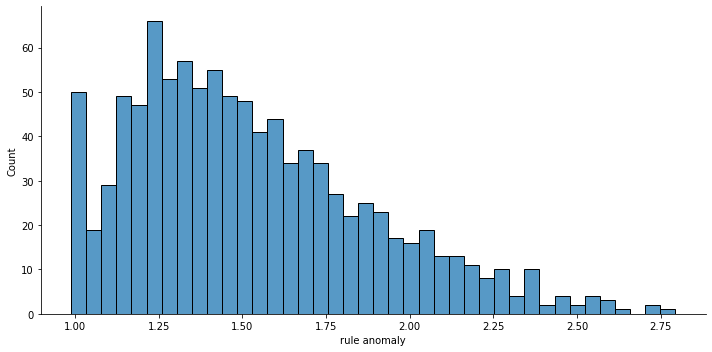

In [252]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({ 'rule anomaly': s_lof })
sns.displot(df, x='rule anomaly', bins=40, aspect=2)


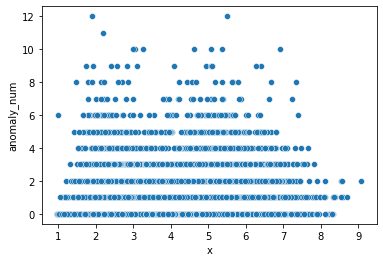

In [240]:
from utils import plot_anomaly
plot_anomaly(mat, r_lof, s_lof, 'rule', 'anomaly_num', anomaly_precent = 0.05, filter_num = 5)

In [244]:
mat0 = (mat.copy().transpose() * r_lof).transpose() * s_lof
mat0 = mat0.transpose()
for i in range(mat0.shape[0]):
    mat0[i] /= mat0[i].sum()
r_dist = pairwise_distances(X = mat0, metric='euclidean')
col_lof = s_lof.copy()
sorted_lof = np.argsort(col_lof)
large_lof = sorted_lof[-5:]


In [245]:
all_r_dist = r_dist.copy().reshape((r_dist.shape[0] * r_dist.shape[1]))
all_r_dist.sort()

In [246]:
print(len(all_r_dist))

1000000


In [62]:
import bisect

1. one cluster or severa

In [250]:
for i in large_lof:
    print('#', i, col_lof[i])#, rules[i]['range'])
    nearests = np.argsort(r_dist[i])[1:5]
    print('Similar:')
    for j in nearests:
        print('#', j, r_dist[i][j], bisect.bisect(all_r_dist, r_dist[i][j]) / len(all_r_dist), col_lof[j])#, rules[j]['range'])
    print('---------------------------------------------')

# 82 2.581242203806541
Similar:
# 153 0.11970164453374443 0.001974 2.467375023099847
# 114 0.12142393176881103 0.002398 2.355375898480174
# 226 0.12146307761111261 0.002402 2.357654142566709
# 773 0.1232374940942723 0.003116 1.9044371453840463
---------------------------------------------
# 479 2.622471763874152
Similar:
# 645 0.12600761823199716 0.005488 2.094995481766408
# 837 0.12715824877566834 0.007248 2.2053215709037803
# 869 0.12719870511739392 0.007312 2.0983489597674305
# 633 0.12727146256962038 0.00747 2.5124313222421444
---------------------------------------------
# 13 2.705227510431259
Similar:
# 426 0.11900204197497706 0.001852 2.066679625102103
# 251 0.11936829323843755 0.001904 1.9241333018970814
# 939 0.12109680358333239 0.002284 2.5180673381473686
# 730 0.12113809819327387 0.002298 1.6687184470619194
---------------------------------------------
# 986 2.718657083975745
Similar:
# 977 0.12007925706163007 0.002066 2.1229741965072955
# 241 0.12158090486956835 0.002438 1.